<a href="https://colab.research.google.com/github/adityamwagh/hpml-hw/blob/master/HPML_hw3_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#code from https://github.com/intoli/intoli-article-materials/blob/master/articles/neural-network-initialization/utils.py

from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
import keras

from matplotlib import rcParamsDefault
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras import initializers
from tensorflow.keras.datasets import mnist

def grid_axes_it(n_plots, n_cols=3, enumerate=False, fig=None):
    """
    Iterate through Axes objects on a grid with n_cols columns and as many
    rows as needed to accommodate n_plots many plots.
    Args:
        n_plots: Number of plots to plot onto figure.
        n_cols: Number of columns to divide the figure into.
        fig: Optional figure reference.
    Yields:
        n_plots many Axes objects on a grid.
    """
    n_rows = n_plots / n_cols + int(n_plots % n_cols > 0)

    if not fig:
        default_figsize = rcParamsDefault['figure.figsize']
        fig = plt.figure(figsize=(
            default_figsize[0] * n_cols,
            default_figsize[1] * n_rows
        ))

    for i in range(1, n_plots + 1):
        ax = plt.subplot(n_rows, n_cols, i)
        yield ax


def create_mlp_model(
    n_hidden_layers,
    dim_layer,
    input_shape,
    n_classes,
    kernel_initializer,
    bias_initializer,
    activation,
):
    """Create Multi-Layer Perceptron with given parameters."""
    model = Sequential()
    model.add(Dense(dim_layer, input_shape=input_shape, kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    for i in range(n_hidden_layers):
        model.add(Dense(dim_layer, activation=activation, kernel_initializer=kernel_initializer,
                        bias_initializer=bias_initializer))
    model.add(Dense(n_classes, activation='softmax', kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def create_cnn_model(input_shape, num_classes, kernel_initializer='glorot_uniform',
                     bias_initializer='zeros'):
    """Create CNN model similar to
       https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py."""
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(Conv2D(64, (3, 3), activation='relu',
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax',
                    kernel_initializer=kernel_initializer,
                    bias_initializer=bias_initializer))
    return model


def compile_model(model):
    model.compile(loss=categorical_crossentropy,
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    return model


def get_init_id(init):
    """
    Returns string ID summarizing initialization scheme and its parameters.
    Args:
        init: Instance of some initializer from keras.initializers.
    """
    try:
        init_name = str(init).split('.')[2].split(' ')[0]
    except:
        init_name = str(init).split(' ')[0].replace('.', '_')

    param_list = []
    config = init.get_config()
    for k, v in config.items():
        if k == 'seed':
            continue
        param_list.append('{k}-{v}'.format(k=k, v=v))
    init_params = '__'.join(param_list)

    return '|'.join([init_name, init_params])


def get_activations(model, x):
    """Extract activations with given model and input vector x."""
    outputs = [layer.output for layer in model.layers]
    activations = K.function([model.input], outputs)
    output_elts = activations([x])
    return output_elts


class LossHistory(keras.callbacks.Callback):
    """A custom keras callback for recording losses during network training."""

    def on_train_begin(self, logs={}):
        self.losses = []
        self.epoch_losses = []
        self.epoch_val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

    def on_epoch_end(self, epoch, logs={}):
        self.epoch_losses.append(logs.get('loss'))
        self.epoch_val_losses.append(logs.get('val_loss'))

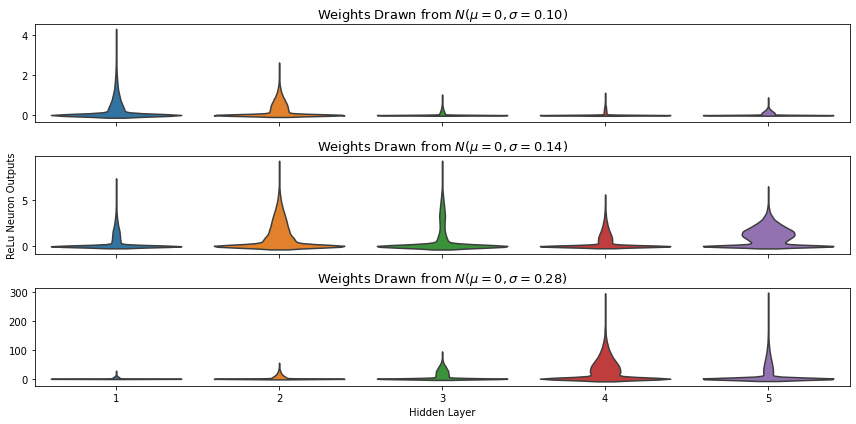

In [ ]:
# code from https://github.com/intoli/intoli-article-materials/blob/master/articles/neural-network-initialization/plot-activation-layers.py

# import keras
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import seaborn as sns
# from keras import initializers
# from keras.datasets import mnist

# from utils import (
#     compile_model,
#     create_mlp_model,
#     get_activations,
#     grid_axes_it,
# )


seed = 10

# Number of points to plot
n_train = 1000
n_test = 100
n_classes = 10

# Network params
n_hidden_layers = 5
dim_layer = 100
batch_size = n_train
epochs = 1

# Load and prepare MNIST dataset.
n_train = 60000
n_test = 10000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
num_classes = len(np.unique(y_test))
data_dim = 28 * 28

x_train = x_train.reshape(60000, 784).astype('float32')[:n_train]
x_test = x_test.reshape(10000, 784).astype('float32')[:n_train]
x_train /= 255
x_test /= 255

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

# Run the data through a few MLP models and save the activations from
# each layer into a Pandas DataFrame.
rows = []
sigmas = [0.10, 0.14, 0.28]
for stddev in sigmas:
    init = initializers.RandomNormal(mean=0.0, stddev=stddev, seed=seed)
    activation = 'relu'

    model = create_mlp_model(
        n_hidden_layers,
        dim_layer,
        (data_dim,),
        n_classes,
        init,
        'zeros',
        activation
    )
    compile_model(model)
    output_elts = get_activations(model, x_test)
    n_layers = len(model.layers)
    i_output_layer = n_layers - 1

    for i, out in enumerate(output_elts[:-1]):
        if i > 0 and i != i_output_layer:
            for out_i in out.ravel()[::20]:
                rows.append([i, stddev, out_i])

df = pd.DataFrame(rows, columns=['Hidden Layer', 'Standard Deviation', 'Output'])

# Plot previously saved activations from the 5 hidden layers
# using different initialization schemes.
fig = plt.figure(figsize=(12, 6))
axes = grid_axes_it(len(sigmas), 1, fig=fig)
for sig in sigmas:
    ax = next(axes)
    ddf = df[df['Standard Deviation'] == sig]
    sns.violinplot(x='Hidden Layer', y='Output', data=ddf, ax=ax, scale='count', inner=None)

    ax.set_xlabel('')
    ax.set_ylabel('')

    ax.set_title('Weights Drawn from $N(\mu = 0, \sigma = {%.2f})$' % sig, fontsize=13)

    if sig == sigmas[1]:
        ax.set_ylabel("ReLu Neuron Outputs")
    if sig != sigmas[-1]:
        ax.set_xticklabels(())
    else:
        ax.set_xlabel("Hidden Layer")

plt.tight_layout()
plt.show()